In [1]:
# import libs
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import tables
from random import shuffle
from IPython.display import clear_output
from sklearn import metrics
from tqdm import tqdm
import time
import seaborn as sns
import os
%matplotlib inline

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
print(os.listdir('../JUNO/Datasets/'))

['train_lpmt_hits.h5', 'spmt_pos.csv', 'train_spmt_hits_small.csv', '.DS_Store', 'train_lpmt_n_hits.csv', 'train_lpmt_hits_small.csv', 'train_spmt_n_hits.csv', 'train_info.csv', 'train_spmt_hits.h5', 'lpmt_pos.csv', '.csv.train_lpmt_hits_small.csv']


# Data Description

**lpmt** — большие ФЭУ, **spmt** — маленькие, **hits** — зарегистрированные фото-электроны (не все фотоны выбивают фото-электрон, и не всякий фото-электрон регистрируется). Каждый hit имеет 3 характеристики: номер ФЭУ (pmtID), время от физического события в детекторе (hitTime) и происхождение (isDN=0 для нормальных хитов, isDN=1 для шума в самих ФЭУ).
В каждом физическом событии может быть переменное количество хитов. Количество хитов сохранено в переменной nHits. Технически nHits — это длина массивов pmtID, hitTime и isDN в каждом событии.
В **train_info** записаны данные, которые нельзя напрямую измерить, но можно предсказывать: E — энергия в МэВ; x,y,z,R — координаты в мм (R^2 = x^2+y^2+z^2). События в деревьях соответствуют друг другу по порядковому номеру: певрое из **train_info** соответствует первому из **lpmt_hits** и первому из **spmt_hits**.
lpmt_pos и spmt_pos — это координаты ФЭУ (x, y, z в миллиметрах).

In [9]:
Datasets = dict()
for file in os.listdir("../JUNO/Datasets"):
    if file.split('.')[1] == 'csv' and file.split('.')[1] in ('train_spmt_hits_small', 'train_lpmt_hits_small'):
        Datasets[file.split('.')[0]] = pd.read_csv('../JUNO/Datasets/' + str(file), sep='\t')
    elif file.split('.')[1] == 'h5':
        Datasets[file.split('.')[0]] = pd.read_hdf('../JUNO/Datasets/' + str(file), mode='r')
    else:
        Datasets[file.split('.')[0]] = pd.read_csv('../JUNO/Datasets/' + str(file))
        
    

In [10]:
# TOP 5 string from DataFrames
for file in Datasets:
    print('File Name: ', file)
    print(Datasets[file].head(), end='\n')
#     print(Datasets[file].describe(), end='\n')
    print()

File Name:  train_lpmt_hits
   event     hitTime   isDN  pmtID
0      0  249.992615  False  14175
1      0   40.010311  False  17319
2      0  162.123199  False  16882
3      0   51.875614  False  14951
4      0   79.817497  False  10947

File Name:  spmt_pos
   pmt_id         pmt_x       pmt_y      pmt_z
0  300000  1.384810e+03   244.17944  19148.438
1  300001  1.217782e+03   703.08670  19148.438
2  300002  9.038709e+02  1077.19130  19148.438
3  300003  4.809396e+02  1321.37070  19148.438
4  300004  8.610328e-14  1406.17330  19148.438

File Name:  train_spmt_hits_small
   event     hitTime   isDN   pmtID
0      0  238.278090  False  311819
1      0  103.316055  False  307244
2      0  108.034225  False  323230
3      0   36.505154  False  320568
4      0   34.109840  False  316487

File Name:  
   Unnamed: 0  event     hitTime   isDN  pmtID
0           0      0  249.992610  False  14175
1           1      0   40.010310  False  17319
2           2      0  162.123200  False  16882
3    

In [11]:
# rename columns for joining
Datasets['train_lpmt_n_hits'].rename(index=str, columns={"event_id": "event"}, inplace=True)
Datasets['train_spmt_n_hits'].rename(index=str, columns={"event_id": "event"}, inplace=True)
;

''

In [13]:
# True False - 1 0 
Datasets['train_lpmt_hits_small']['isDN'] = Datasets['train_lpmt_hits_small'].isDN.apply(
    lambda x: 1 if x == True else 0
)
Datasets['train_spmt_hits_small']['isDN'] = Datasets['train_spmt_hits_small'].isDN.apply(
    lambda x: 1 if x == True else 0
)

In [14]:
# myDataFrame = pd.merge(Datasets['train_lpmt_hits'], Datasets['train_lpmt_n_hits'], how='inner', on='event')

## Посчитаем процент нормальных хитов от общего кол-ва хитов для каждого детектора

In [15]:
# train_lpmt_n_hits: Добавляем кол-во нормальных хитов для каждого детектора
myDataFrame1 = pd.DataFrame(
    Datasets['train_lpmt_hits_small'][Datasets['train_lpmt_hits_small'].isDN == True].groupby('pmtID').size(),
    columns=['nHitsTrue']
)
myDataFrame1.reset_index(inplace=True)
# Datasets['train_lpmt_n_hits'] = pd.merge(
#     myDataFrame, 
#     Datasets['train_lpmt_n_hits'], 
#     how='inner', on='event'
# )
# Datasets['train_lpmt_n_hits']['procTrue'] = Datasets['train_lpmt_n_hits'].apply(
#     lambda row: row.nHitsTrue/row.nHits,
#     axis=1
# )
myDataFrame2 = pd.DataFrame(
    Datasets['train_lpmt_hits_small'].groupby('pmtID').size(),
    columns=['nHits']
)
myDataFrame2.reset_index(inplace=True)
Datasets['info_lpmt_det'] = pd.merge(
    myDataFrame1, 
    myDataFrame2, 
    how='inner', on='pmtID'
)
Datasets['info_lpmt_det']['procTrue'] = Datasets['info_lpmt_det'].apply(
    lambda row: row.nHitsTrue/row.nHits,
    axis=1
)


In [16]:
# train_spmt_n_hits: Добавляем кол-во нормальных хитов для каждого детектора
myDataFrame1 = pd.DataFrame(
    Datasets['train_spmt_hits_small'][Datasets['train_spmt_hits_small'].isDN == True].groupby('pmtID').size(),
    columns=['nHitsTrue']
)
myDataFrame1.reset_index(inplace=True)
# Datasets['train_lpmt_n_hits'] = pd.merge(
#     myDataFrame, 
#     Datasets['train_lpmt_n_hits'], 
#     how='inner', on='event'
# )
# Datasets['train_lpmt_n_hits']['procTrue'] = Datasets['train_lpmt_n_hits'].apply(
#     lambda row: row.nHitsTrue/row.nHits,
#     axis=1
# )
myDataFrame2 = pd.DataFrame(
    Datasets['train_spmt_hits_small'].groupby('pmtID').size(),
    columns=['nHits']
)
myDataFrame2.reset_index(inplace=True)
Datasets['info_spmt_det'] = pd.merge(
    myDataFrame1, 
    myDataFrame2, 
    how='inner', on='pmtID'
)
Datasets['info_spmt_det']['procTrue'] = Datasets['info_spmt_det'].apply(
    lambda row: row.nHitsTrue/row.nHits,
    axis=1
)

In [17]:
Datasets['info_spmt_det'].sort_values(by='procTrue', ascending=False, inplace=True)
Datasets['info_lpmt_det'].sort_values(by='procTrue', ascending=False, inplace=True)

In [18]:
# rename columns for joining
Datasets['lpmt_pos'].rename(index=str, columns={"pmt_id": "pmtID"}, inplace=True)
Datasets['spmt_pos'].rename(index=str, columns={"pmt_id": "pmtID"}, inplace=True)
;

''

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

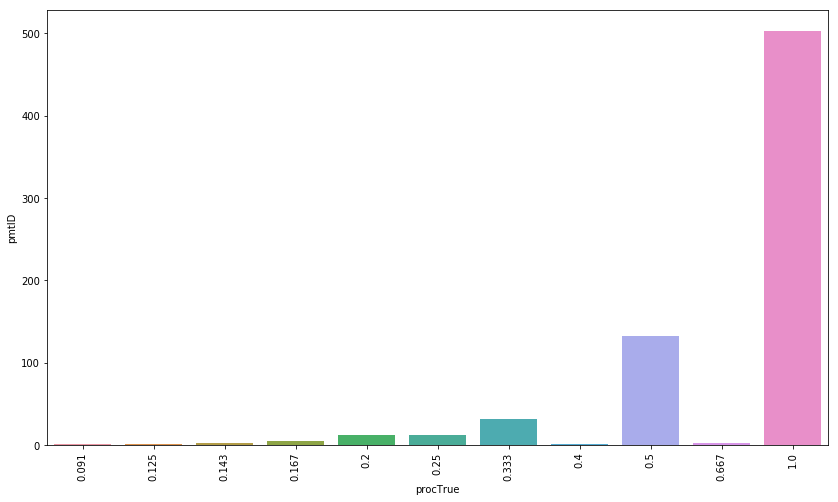

In [19]:
Datasets['info_lpmt_det'].procTrue = Datasets['info_lpmt_det'].procTrue.apply(lambda x: round(x, 3))

#Распределение не шума в больших детекторах
plt.figure(figsize=(14,8))
sns.barplot(x='procTrue', y='pmtID', data=Datasets['info_lpmt_det'].groupby('procTrue', as_index = False)['pmtID'].count())
plt.xticks(rotation=90)

(array([0]), <a list of 1 Text xticklabel objects>)

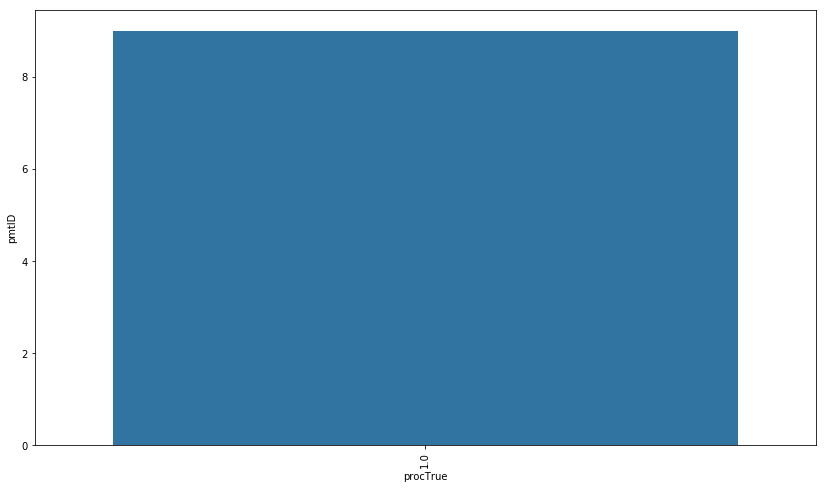

In [20]:
Datasets['info_spmt_det'].procTrue = Datasets['info_spmt_det'].procTrue.apply(lambda x: round(x, 3))

#Распределение не шума в маленьких детекторах
plt.figure(figsize=(14,8))
sns.barplot(x='procTrue', y='pmtID', data=Datasets['info_spmt_det'].groupby('procTrue', as_index = False)['pmtID'].count())
plt.xticks(rotation=90)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a9f830b00>]],
      dtype=object)

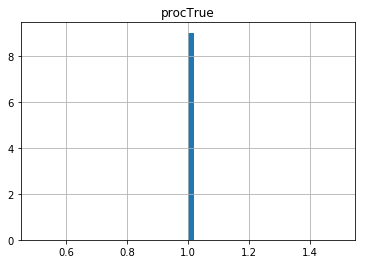

In [21]:
Datasets['info_spmt_det'][['procTrue']].hist(bins=50)

In [22]:
myData=Datasets['info_spmt_det'].groupby('procTrue', as_index = False)['pmtID'].count()
myData.head(30)

procTrue  pmtID
0       1.0      9

In [23]:
# добавляем координаты для каждого детектора
Datasets['info_spmt_det'] = pd.merge(
    Datasets['info_spmt_det'],
    Datasets['spmt_pos'],
    how='inner', on='pmtID'
)

Datasets['info_lpmt_det'] = pd.merge(
    Datasets['info_lpmt_det'],
    Datasets['lpmt_pos'],
    how='inner', on='pmtID'
)

In [24]:
# Добавляем цвет для детекторов
Datasets['info_lpmt_det']['color'] = Datasets['info_lpmt_det'].procTrue.apply(
    lambda x: 'red' if x <= 0.043 else 'orange'
)
      
    
Datasets['info_spmt_det']['color'] = Datasets['info_spmt_det'].procTrue.apply(
    lambda x: 'black' if x <= 0.016 else 'white'
)
   

In [25]:
# Добавляем цвет для детекторов
# lpmt_hits_mask = []
# for i in range(Datasets['info_lpmt_det'].shape[0]):
#     if i <= 20:
#         lpmt_hits_mask.append("r")
#     else:
#         lpmt_hits_mask.append("w")
        
# spmt_hits_mask = []
# for i in range(Datasets['info_spmt_det'].shape[0]):
#     if i <= 20:
#         spmt_hits_mask.append("g")
#     else:
#         spmt_hits_mask.append("w")

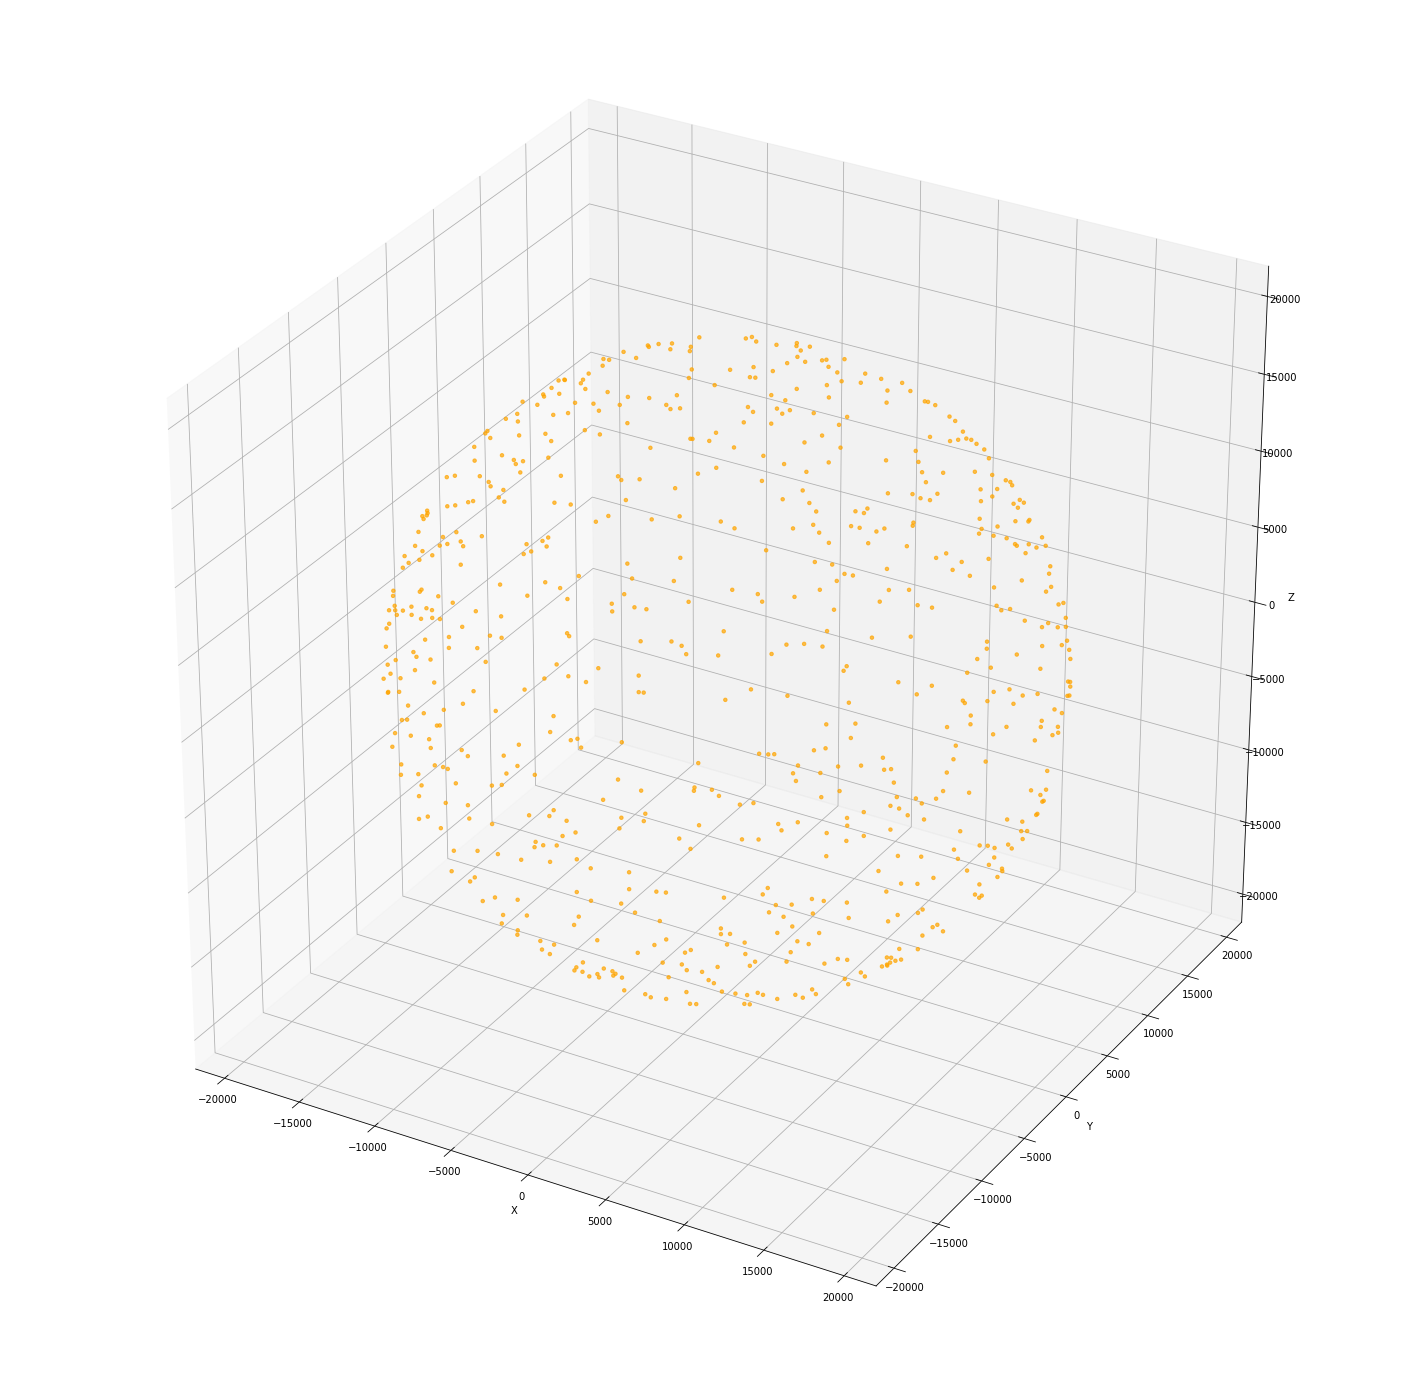

In [26]:
# Распределение больших детекторов
fig = plt.figure(figsize=(25, 25))
ax = fig.add_subplot(111, projection='3d')

x = Datasets['info_lpmt_det']['pmt_x']
y = Datasets['info_lpmt_det']['pmt_y']
z = Datasets['info_lpmt_det']['pmt_z']

ax.scatter(x, y, z, c=Datasets['info_lpmt_det']['color'], marker='o', s=12, alpha=0.7)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# x = Datasets['info_spmt_det']['pmt_x']
# y = Datasets['info_spmt_det']['pmt_y']
# z = Datasets['info_spmt_det']['pmt_z']

# ax.scatter(x, y, z, c=spmt_hits_mask, marker='o', s=12, alpha=0.7)

# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')

plt.show()


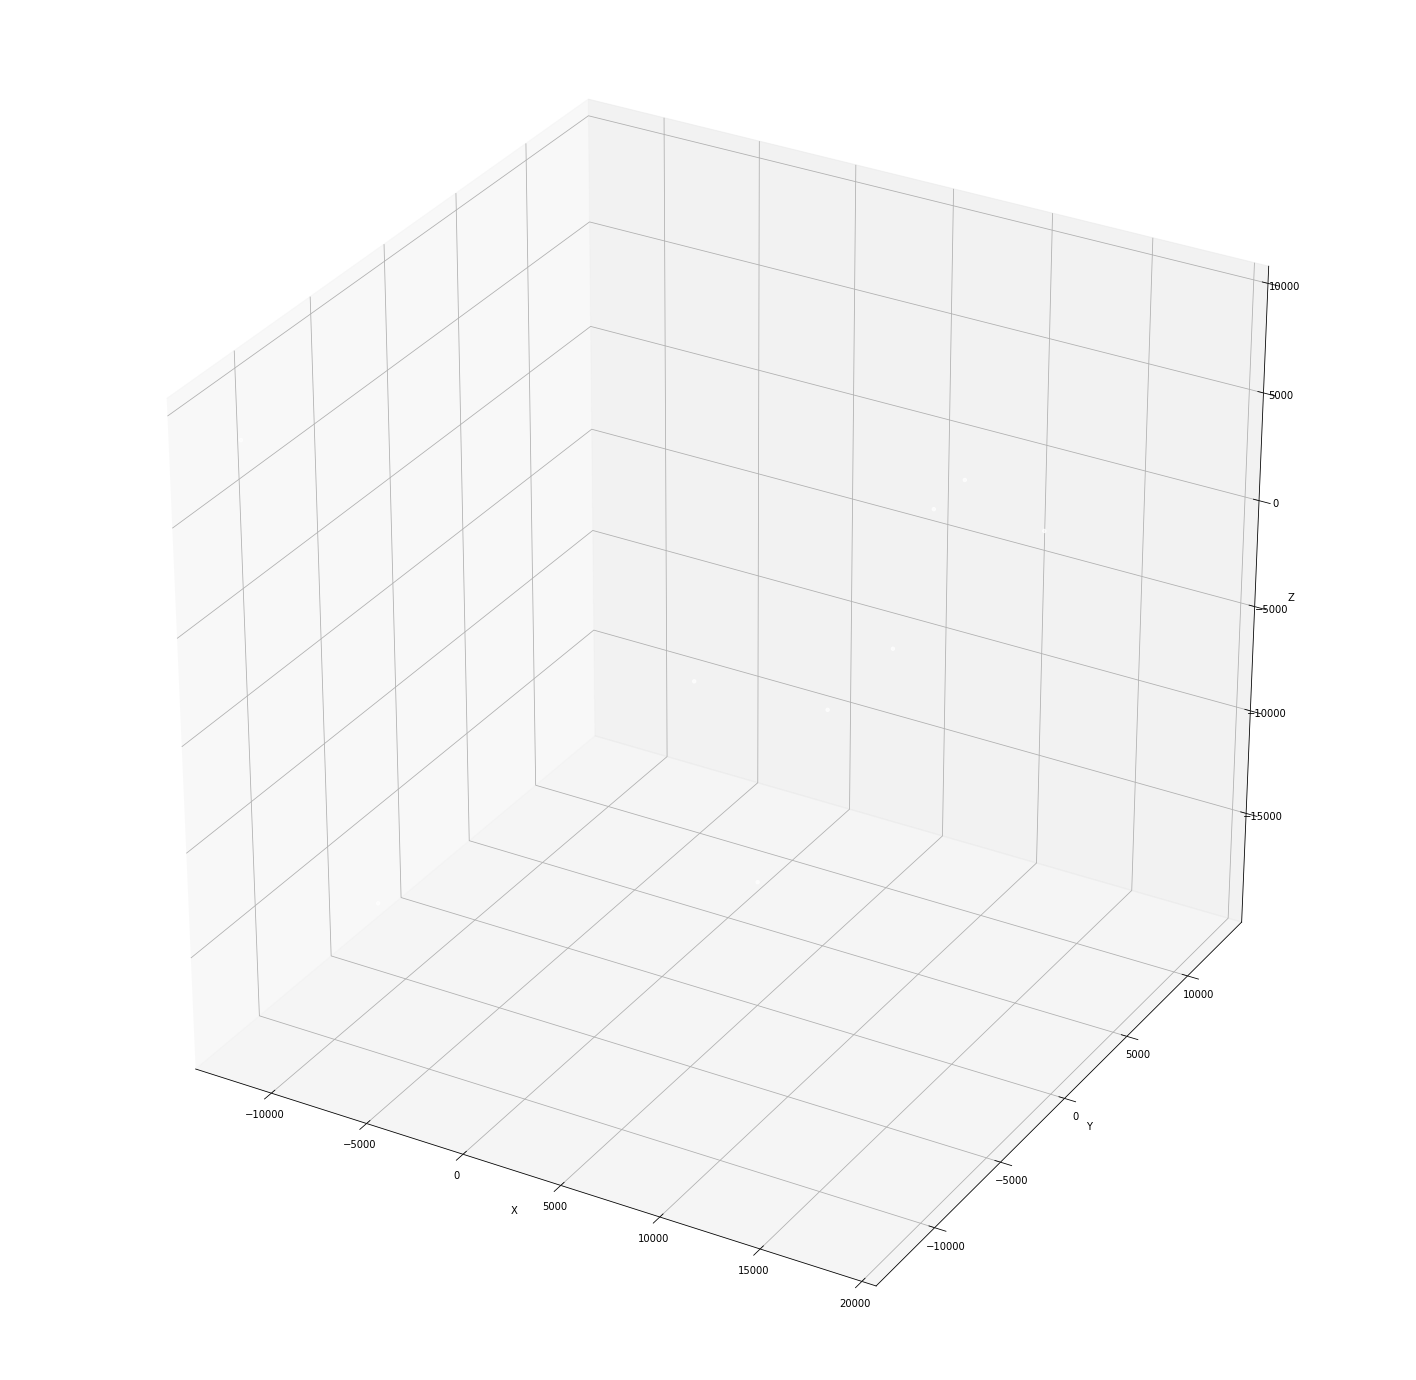

In [27]:
# Распределение маленьких детекторов(из левого пика распределения)
fig = plt.figure(figsize=(25, 25))
ax = fig.add_subplot(111, projection='3d')

x = Datasets['info_spmt_det']['pmt_x']
y = Datasets['info_spmt_det']['pmt_y']
z = Datasets['info_spmt_det']['pmt_z']

ax.scatter(x, y, z, c=Datasets['info_spmt_det']['color'], marker='o', s=12, alpha=0.7)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# x = Datasets['info_spmt_det']['pmt_x']
# y = Datasets['info_spmt_det']['pmt_y']
# z = Datasets['info_spmt_det']['pmt_z']

# ax.scatter(x, y, z, c=spmt_hits_mask, marker='o', s=12, alpha=0.7)

# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')

plt.show()

